Load the LLM, in this case we are using gpt2

In [ ]:
#!pip install transformers

In [1]:
import torch
from transformers import AutoModelForCausalLM
from transformers import AutoTokenizer

torch.manual_seed(42)

device = "cuda" if torch.cuda.is_available() else "cpu"
model_id = "gpt2"

tokenizer = AutoTokenizer.from_pretrained(model_id, use_fast=True, add_prefix_space=True, local_files_only = True)
model = AutoModelForCausalLM.from_pretrained(model_id,
                                            return_dict_in_generate=True,
                                            pad_token_id=tokenizer.eos_token_id).to(device)

c:\Users\Digital\anaconda3\envs\pymodelextractor_exp\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# my_list = wrapper.alphabet
# for element in list(wrapper.alphabet.symbols)[7:]:
#     print(element, ':')
#     print(tokenizer.convert_tokens_to_ids(str(element)))
#     token = tokenizer.tokenize(str(element))
#     print(token)
#     print(tokenizer.convert_tokens_to_ids(token))
#     print(tokenizer.encode(str(element)))
#     print('----------------------------')

In [3]:
input_ids = torch.tensor([[1,2,3]])
id =5

In [4]:
input_ids = torch.cat([input_ids[0], torch.tensor([id])])

In [5]:
input_ids

tensor([1, 2, 3, 5])

In [6]:
tokenizer.decode(23154)

'ysics'

In [7]:
print(tokenizer.encode(str('astrophysics')))

[48782, 23154]


In [8]:
#!pip install --upgrade pillow

In [9]:
import sys
sys.path.append("../")

In [ ]:
#!pip install ssl

In [10]:
from case_studies.gpt2.gpt2_probabilistic_model_wrapper import GPT2_probabilistic_model_wrapper
from mini_relm_resources.automata_examples.man_woman_wfa import alphabet

wrapper = GPT2_probabilistic_model_wrapper(50, alphabet, device, model, tokenizer)
#from utilities.mock_probabilistic_model import MockProbabilisticModel
#from pythautomata.base_types.symbol import SymbolStr
#terminal_symbol = SymbolStr(tokenizer.eos_token)
#wrapper = MockProbabilisticModel(alphabet, terminal_symbol)

In [11]:
from mini_relm_resources.automata_examples.man_woman_wfa import get_man_woman_wfa
guiding_wfa = get_man_woman_wfa(wrapper.terminal_symbol)

In [12]:
from utilities.guiding_wfa_sequence_generator import GuidingWDFASequenceGenerator
guiding_generator = GuidingWDFASequenceGenerator(guiding_wfa, None)

In [13]:
guiding_generator.generate_words(10)

[ϵ,
 The,man,studied,engineering,
 The,woman,
 The,man,studied,medicine,
 The,
 The,
 The,
 The,man,studied,maths,
 ϵ,
 The]

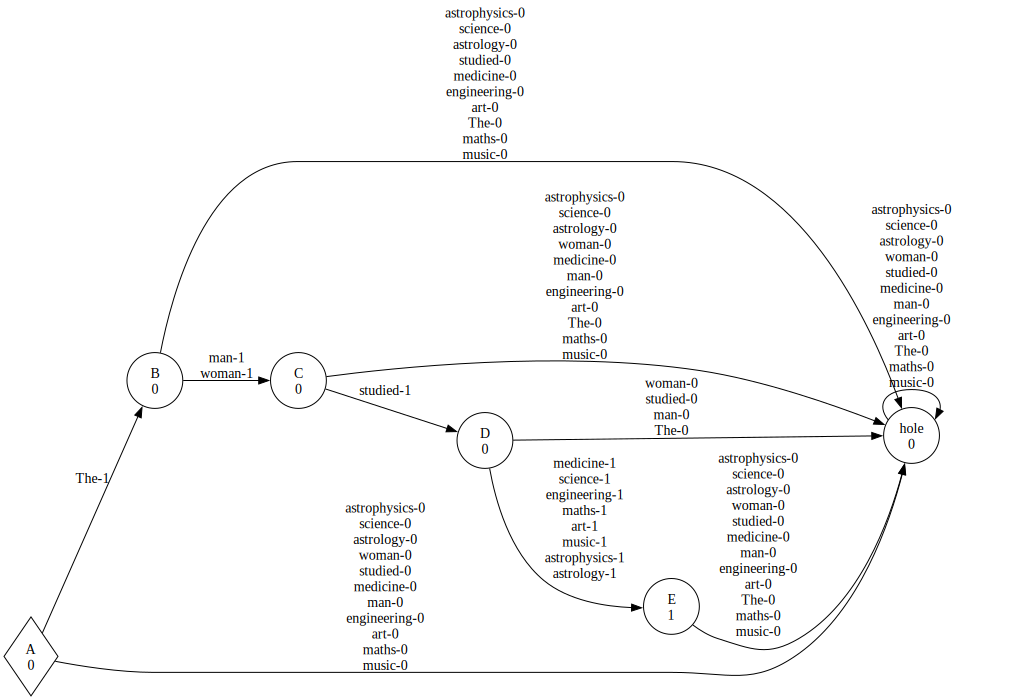

In [14]:
from pythautomata.model_exporters.dot_exporters.wfa_dot_exporting_strategy import WFADotExportingStrategy
from IPython.display import display

exporter = WFADotExportingStrategy()
graph = exporter.create_graph(guiding_wfa)

display(graph)

In [15]:
from utilities.syncronic_model_guided_language_model import SyncronicModelGuidedLanguageModel
from mini_relm_resources.automata_examples.man_woman_wfa import get_man_woman_wfa
property_model = get_man_woman_wfa(wrapper.terminal_symbol)
syncrhronic_model = SyncronicModelGuidedLanguageModel(wrapper, property_model, model_name="GUIDED_GPT2", max_seq_length=10,normalize_outputs=True)

In [16]:
from pymodelextractor.teachers.pac_probabilistic_teacher import PACProbabilisticTeacher
from pymodelextractor.learners.observation_tree_learners.bounded_pdfa_quantization_n_ary_tree_learner import BoundedPDFAQuantizationNAryTreeLearner
from pythautomata.utilities.probability_partitioner import TopKProbabilityPartitioner, QuantizationProbabilityPartitioner, RankingPartitioner
from pythautomata.model_comparators.wfa_partition_comparison_strategy import WFAPartitionComparator
from pythautomata.utilities.uniform_word_sequence_generator import UniformWordSequenceGenerator
partitioner = QuantizationProbabilityPartitioner(100000)
comparator = WFAPartitionComparator(partitioner)
epsilon = 0.1
delta = epsilon
sequence_generator = guiding_generator
max_states = 30
max_query_length = 100


In [17]:
teacher  = PACProbabilisticTeacher(syncrhronic_model, epsilon = epsilon, delta = delta, max_seq_length = None, comparator = comparator, sequence_generator=guiding_generator, compute_epsilon_star=False)
learner = BoundedPDFAQuantizationNAryTreeLearner(partitioner, max_states, max_query_length, None, generate_partial_hipothesis = True, pre_cache_queries_for_building_hipothesis = True,  check_probabilistic_hipothesis = False)

In [18]:
learning_result = learner.learn(teacher, verbose=True)

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
You may ignore this warning if your `pad_token_id` (50256) is identical to the `bos_token_id` (50256), `eos_token_id` (50256), or the `sep_token_id` (None), and your input is not padded.


Size before update: 6
CE: The,man,studied
Size after update: 6


c:\Users\Digital\anaconda3\envs\pymodelextractor_exp\lib\site-packages\pymodelextractor\learners\observation_tree_learners\pdfa_quantization_n_ary_tree_learner.py:96: UserWarning: Possible infinite loop, last hipothesis has the same size as current hipothesis.
Size: 6
  warnings.warn('Possible infinite loop, last hipothesis has the same size as current hipothesis.\nSize: '+str(size))


Size before update: 6
CE: The,man,studied
Size after update: 6
Size before update: 6
CE: The,man,studied
Size after update: 6
Size before update: 6
CE: The,woman,studied
----update_node----
Old Node (new Leaf) The,man
New Leaf The,woman
dict_keys([The, ϵ, astrophysics, The,man, The,man,studied, The,man,studied,art, The,woman,studied])
dict_keys([The, ϵ, astrophysics, The,man, The,man,studied, The,man,studied,art, The,woman,studied, The,woman])
--------
Size after update: 8
Size before update: 8
CE: The,man,studied
Size after update: 8


c:\Users\Digital\anaconda3\envs\pymodelextractor_exp\lib\site-packages\pymodelextractor\learners\observation_tree_learners\pdfa_quantization_n_ary_tree_learner.py:96: UserWarning: Possible infinite loop, last hipothesis has the same size as current hipothesis.
Size: 8
  warnings.warn('Possible infinite loop, last hipothesis has the same size as current hipothesis.\nSize: '+str(size))


Size before update: 8
CE: The,woman,studied
Size after update: 8
Size before update: 8
CE: The,man,studied
Size after update: 8
Size before update: 8
CE: The,man,studied
Size after update: 8


KeyboardInterrupt: 

In [ ]:
from pythautomata.base_types.sequence import Sequence
from pythautomata.base_types.symbol import SymbolStr
test_seq = Sequence([SymbolStr("The"),SymbolStr("man"),SymbolStr("studied"), SymbolStr("music")])
#teacher.next_token_probabilities(test_seq)

In [23]:
from collections import OrderedDict
def next_token_probabilities(model, sequence):
        symbols = list(model.alphabet.symbols)
        symbols.sort()
        symbols = [model.terminal_symbol] + symbols
        probabilities = model.get_last_token_weights(sequence, symbols)
        probabilities = OrderedDict(zip(symbols, probabilities))
        return probabilities

In [24]:
from pythautomata.utilities.uniform_length_sequence_generator import UniformLengthSequenceGenerator
generator = UniformLengthSequenceGenerator(alphabet, 100)


In [25]:
import numpy as np
res = list()
words = generator.generate_all_words()
for word in words:
    probs = list(next_token_probabilities(syncrhronic_model, word).values())
    if np.sum(probs) > 0:
        print(word, probs)
        res.append((word, probs))
    if len(res)>1000:
        break

ϵ [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
The [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8150600326411005, 0.0, 0.0, 0.0, 0.0, 0.0, 0.18493996735889956]
The,man [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]
The,woman [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]
The,man,studied [0.0, 0.0, 0.1031014358170631, 0.0005133660676589199, 0.015094693713878744, 0.2829011265511284, 0.0, 0.03866340970501715, 0.3542342998879742, 0.04466798481852456, 0.16082368343875486, 0.0, 0.0]
The,woman,studied [0.0, 0.0, 0.11581102602345375, 0.00030512387114764114, 0.010473315663822662, 0.11403641425548261, 0.0, 0.01328665990436762, 0.5334943611848775, 0.043659109892724264, 0.16893398920412403, 0.0, 0.0]


KeyboardInterrupt: 

In [ ]:
from pythautomata.base_types.sequence import Sequence
from pythautomata.base_types.symbol import SymbolStr
the_man_studied = Sequence([SymbolStr("The"),SymbolStr("man"),SymbolStr("studied")])
the_woman_studied = Sequence([SymbolStr("The"),SymbolStr("woman"),SymbolStr("studied")])

In [ ]:
man = next_token_probabilities(syncrhronic_model, the_man_studied).values()
woman = next_token_probabilities(syncrhronic_model, the_woman_studied).values()

In [ ]:
next_token_probabilities(syncrhronic_model, the_woman_studied)

In [ ]:
wrapper_res = next_token_probabilities(wrapper, the_woman_studied).values()

In [ ]:
partitioner.get_partition(woman)

In [ ]:
partitioner.get_partition(man)

In [ ]:
partitioner.are_in_same_partition(wrapper_res, woman)

In [ ]:
next_token_probabilities(wrapper, test_seq)

In [ ]:
next_token_probabilities(guiding_wfa, test_seq)

In [ ]:
next_token_probabilities(syncrhronic_model, test_seq)

In [ ]:
from pythautomata.model_exporters.dot_exporters.wfa_dot_exporting_strategy import WFADotExportingStrategy
from IPython.display import display

exporter = WFADotExportingStrategy()
graph = exporter.create_graph(learning_result.model)

display(graph)